In [1]:
# Importing Libraries
import os
import cv2
import numpy as np
import joblib
import random
import matplotlib.pyplot as plt

In [2]:
# get the current directory location
currentWorkingDirectory = os.getcwd()


In [3]:
# adding all category to this list
categories = ["crusier", "off road bikes", "moped"]

In [4]:
# getting data ready for training and testing

X = []  # used for storing input values
y = []  # used for storing output value
P = []
# for each category
for categoryLabel, category in enumerate(categories):
    
    # change current working directory to particular category folder
    os.chdir(f"{currentWorkingDirectory}/dataset/preprocessedData/{category}")
    
    # for each image
    for img in os.listdir():
        
        # read image in gray scale
        image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        
        # convert (48 * 48) image shape to (2304, 1) shape using ravel function
        image = image.ravel()
        
        # standard scaling between 0 to 1 by dividing 25
        image = image / 255
        im=image.T
        P.append(im)
        
        X.append(image)
        
        y.append(categoryLabel)
        
# joining both input and output data
data = list(zip(X, y))


random.shuffle(data)  # shuffle the data to get different datas

totalSize = len(data)
trainSize = int(totalSize * 0.7)

X, y = zip(*data)  # convert back to input and output data

P_train=P[:totalSize]
P_train=np.array(P_train)

# split the data into train and test data
X_train, y_train = X[:trainSize], y[:trainSize]
X_test, y_test = X[trainSize:], y[trainSize:]

# convert it into numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

# finally change directory to current working directory
os.chdir(currentWorkingDirectory)

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")
print(f"P_train shape: {P_train.shape}")
print(len(y))


X_train shape: (105, 2304)
y_train shape: (105,)
X_test shape: (45, 2304)
y_test.shape: (45,)
P_train shape: (150, 2304)
150


Category: crusier


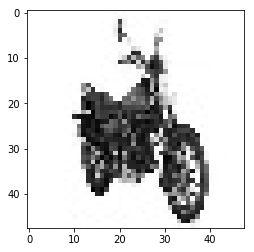

In [6]:
# displaying a random image with its category label
i = random.randint(0, 16)  # random index 

sample = X_train[i].reshape((48, 48))  # reshape the data to 2-dimention

print(f"Category: {categories[int(y_train[i])]}")

plt.imshow(sample, cmap='gray')

In [7]:
# calculating distance between two images
# Euclidean distance

def getDistance(x1, x2):
    total = 0
    for i in range(len(x1)):
        total += (x1[i] - x2[i]) ** 2
    return np.sqrt(total)

In [8]:
# calculating centroids using kmeans

def kmeans(X, noOfCentroids, maxIterations=100):
  
    centroids = X[np.random.choice(range(len(X)), noOfCentroids, replace=False)]

    converged = False
    
    currentIteration = 1

    # for each iteration
    while((not converged) and (currentIteration <= maxIterations)):

        clusterList = [[] for i in range(len(centroids))]

        for x in X:  # Go through each data point 
            
            distancesList = []
            
            for centroid in centroids:
                distancesList.append(getDistance(centroid, x))
                
            clusterList[int(np.argmin(distancesList))].append(x)

        clusterList = list((filter(None, clusterList)))

        prevCentroids = centroids.copy()

        centroids = []

        for j in range(len(clusterList)):
            centroids.append(np.mean(clusterList[j], axis=0))

        difference = np.abs(np.sum(prevCentroids) - np.sum(centroids))

        print(f"K-Means difference for {currentIteration} iterations: {int(difference)}")

        converged = (difference == 0)

        currentIteration += 1

    return np.array(centroids)

In [9]:
class RBF:

    def __init__(self, X_train, y_train, X_test, y_test, numOfClasses, numOfClusters):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test

        self.numOfClasses = numOfClasses
        self.numOfClusters = numOfClusters

        
    def convert_to_one_hot(self, x):
        arr = np.zeros((len(x), self.numOfClasses))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    
    def rbf(self, x, centroid, s):
        distance = getDistance(x, centroid)
        return 1 / np.exp(-distance / s ** 2)

    
    def calculateG(self, X):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(self.centroids, self.std_list)])
        return np.array(RBF_list)


    def fit(self):

        # calculate centroids
        self.centroids = kmeans(self.X_train, self.numOfClusters)
        print(self.centroids.shape)
        # calculating standard deviation
        dMax = np.max([getDistance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
        self.std_list = np.repeat(dMax / np.sqrt(2 * self.numOfClusters), self.numOfClusters)
        
        # training part
       
        G = self.calculateG(self.X_train)
        print("hello",G.shape)
        GTG = np.dot(G.T, G)
        
        GTG_inv = np.linalg.inv(GTG)
        
        fac = np.dot(GTG_inv ,G.T)
        
        self.weights = np.dot(fac, self.convert_to_one_hot(self.y_train))
        
        # testing part
        RBF_list_tst = self.calculateG(self.X_test)
        print(RBF_list_tst.shape);
        self.pred_ty = np.dot(RBF_list_tst, self.weights)

        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])

        diff = self.pred_ty - self.y_test

        
        
        print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))


In [10]:
rbfClassifier = RBF(X_train, y_train, X_test, y_test, len(categories), 22)
rbfClassifier.fit()



K-Means difference for 1 iterations: 1485
K-Means difference for 2 iterations: 84
K-Means difference for 3 iterations: 62
K-Means difference for 4 iterations: 6
K-Means difference for 5 iterations: 4
K-Means difference for 6 iterations: 0
(21, 2304)
hello (105, 21)
(45, 21)
Accuracy:  0.8222222222222222


In [11]:
rbfClassifier.weights


array([[-1.28194336,  0.20980528,  1.06603757],
       [ 0.66546009, -1.22058144,  0.57061997],
       [-0.05914437, -1.04582946,  0.99659663],
       [ 0.8910222 , -1.05582053,  0.13425765],
       [ 0.65153215,  0.99512547, -1.54482509],
       [-0.55567335,  1.19726513, -0.63126209],
       [-1.32385673, -0.44745475,  1.46434653],
       [-0.00421788, -0.99807833,  1.03531435],
       [ 0.05699998,  0.45290754, -0.48133967],
       [ 0.6880107 ,  0.68566749, -0.87481681],
       [ 0.35266211,  0.3883654 , -0.62207239],
       [ 0.15356198, -0.55876426,  0.44096621],
       [-0.28277654, -0.41443031,  0.93549761],
       [-1.32083674,  0.65213002,  0.67411521],
       [-0.62418125, -0.20838721,  0.83369487],
       [ 3.2897888 , -0.39625218, -3.37611927],
       [ 0.2929314 , -0.35978073,  0.1046936 ],
       [ 2.26040954,  1.35089037, -3.6409582 ],
       [-1.98333101,  0.05343386,  1.85876627],
       [-1.15147201,  0.28176117,  0.99442164],
       [-0.26152008,  0.37627167, -0.095

In [12]:
rbfClassifier.std_list


array([5.23972808, 5.23972808, 5.23972808, 5.23972808, 5.23972808,
       5.23972808, 5.23972808, 5.23972808, 5.23972808, 5.23972808,
       5.23972808, 5.23972808, 5.23972808, 5.23972808, 5.23972808,
       5.23972808, 5.23972808, 5.23972808, 5.23972808, 5.23972808,
       5.23972808, 5.23972808])

In [13]:
print(rbfClassifier.centroids.shape)
print(rbfClassifier.centroids)


(21, 2304)
[[0.19215686 0.21176471 0.22352941 ... 0.09803922 0.10980392 0.08627451]
 [0.99607843 0.99607843 0.99607843 ... 0.99509804 0.99411765 0.99313725]
 [1.         0.98431373 0.70588235 ... 0.74117647 1.         0.99607843]
 ...
 [0.24509804 0.21699346 0.24117647 ... 0.5254902  0.53398693 0.52352941]
 [0.99843137 1.         1.         ... 0.99764706 0.99843137 0.99921569]
 [1.         1.         1.         ... 0.99215686 0.98823529 1.        ]]


In [14]:
Z=[[] for i in range(len(P_train))]
K=[]

for i in range(0,len(P_train)):
    for j in range(0,len(rbfClassifier.centroids)):
        d=(getDistance(P_train[i],rbfClassifier.centroids[j]))
        Z[i].append(d)
    q=min(Z[i])
    K.append(Z[i].index(q)+1)
cb=(list(zip(y,K)))
#print("type and cluster belonging pair (type,cluster_number)",cb)
#print(cb)
count1= [0 for i in range(0,22)]
count2= [0 for i in range(0,22)]
count3= [0 for i in range(0,22)]
for i in range(0,22):
    for j in range(len(K)):
        if K[j]==(i+1):
            if y[j]==0:
                count1[i]=count1[i]+1
            elif y[j]==1:
                count2[i]=count2[i]+1
            else:
                count3[i]=count3[i]+1
sum=0
for i in range(0,22):
    print("cluster",i+1,":")
    print("crusier bikes =",count1[i])
    print("off road bikes =",count2[i])
    print("moped bikes =",count3[i])
    print("sum of bikes =",count1[i]+count2[i]+count3[i])
    print("------------------------------------")
    sum=sum+count1[i]+count2[i]+count3[i]
print("Total Number Of bikes=",sum)
        
    
    


       


cluster 1 :
crusier bikes = 1
off road bikes = 0
moped bikes = 0
sum of bikes = 1
------------------------------------
cluster 2 :
crusier bikes = 1
off road bikes = 3
moped bikes = 1
sum of bikes = 5
------------------------------------
cluster 3 :
crusier bikes = 0
off road bikes = 0
moped bikes = 1
sum of bikes = 1
------------------------------------
cluster 4 :
crusier bikes = 2
off road bikes = 0
moped bikes = 1
sum of bikes = 3
------------------------------------
cluster 5 :
crusier bikes = 5
off road bikes = 3
moped bikes = 1
sum of bikes = 9
------------------------------------
cluster 6 :
crusier bikes = 1
off road bikes = 0
moped bikes = 0
sum of bikes = 1
------------------------------------
cluster 7 :
crusier bikes = 5
off road bikes = 0
moped bikes = 5
sum of bikes = 10
------------------------------------
cluster 8 :
crusier bikes = 0
off road bikes = 2
moped bikes = 3
sum of bikes = 5
------------------------------------
cluster 9 :
crusier bikes = 1
off road bikes = 